## 1) simple example of generating data and then estimating covariance matrix with graphical lasso

In [2]:
import numpy as np
Cov = np.array([[5/8, 1/8, -1/4],
                [1/8, 5/8, -1/4],
                [-1/4, -1/4,  1/2]])
Prec = np.array([[2, 0, 1],
                 [0, 2, 1],
                 [1, 1, 3]])


In [9]:
import numpy as np
np.random.seed(0)
N = 50000
mean = np.zeros(3)
data = np.random.multivariate_normal(mean, Cov, size=N)

In [11]:
from sklearn.covariance import GraphicalLasso
model = GraphicalLasso(alpha=0.01, max_iter=1000)
model.fit(data)
estimated_precision = model.precision_
print(estimated_precision)

[[ 1.96124237e+00 -1.75274990e-03  9.32646981e-01]
 [-1.75274990e-03  1.96487758e+00  9.57173424e-01]
 [ 9.32646981e-01  9.57173424e-01  2.94040049e+00]]


# Synthetic Data Generation: Market Dynamics and Conditional Independence

## Objective
To simulate synthetic data representing two groups in a market with specific dynamics, analyze changes due to market events, and estimate the resulting covariance matrices to identify conditional independencies.

---

## Setup and Dynamics

### Initial Configuration
1. **Groups and Variables**:
   - **Group 1**:
     - 3 stocks.
     - 1 index associated with these stocks.
   - **Group 2**:
     - 2 stocks.
     - 1 index associated with these stocks.

2. **Dynamic Relationships**:
   - **Indexes**:
     - Correlated and conditionally correlated:
       - Knowing one index provides additional information about the other, regardless of other variables.
   - **Stocks within a group**:
     - Correlated and conditionally correlated:
       - Knowing one stock provides additional information about the others in the same group, regardless of other variables.
   - **Stocks between groups**:
     - Conditionally independent:
       - Stocks in different groups are independent given the indexes and other stocks in their respective groups.

3. **Matrix Constraints**:
   - **Precision Matrix** (inverse covariance matrix):
     - Reflects the above dynamics, including zeros for conditional independence.
     - Must be positive definite for invertibility.
   - **Covariance Matrix**:
     - Derived analytically from the precision matrix.

4. **Data Generation**:
   - Generate synthetic data for a time horizon \( T \) based on the defined dynamics.

---

### Market Change: Partial Acquisition Scenario

1. **Dynamic Shift**:
   - Partial acquisition between Group 1 and Group 2 changes the dynamics:
     - Stocks in the two groups are no longer conditionally independent.
     - Knowing a stock in one group now provides additional information about stocks in the other group.

2. **Matrix Adjustment**:
   - Update the precision matrix:
     - Add non-zero coefficients for newly dependent variables.
     - Ensure no changes to other zero coefficients to preserve the original conditional independence relationships.
     - Maintain positive definiteness to ensure invertibility.

3. **New Data Generation**:
   - Generate synthetic data for another time horizon \( T' \) based on the updated dynamics.

---

## Implementation Plan

### Step 1: Generate Initial Precision Matrix
- Construct the precision matrix to reflect the initial relationships:
  - Correlations between stocks and indexes within the same group.
  - Conditional independence between groups.
- Ensure positive definiteness of the precision matrix.

### Step 2: Compute Covariance Matrix
- Compute the covariance matrix analytically as the inverse of the precision matrix.

### Step 3: Generate Synthetic Data
- Use the covariance matrix to generate multivariate normal data for time horizon \( T \).

### Step 4: Modify Precision Matrix
- Adjust the precision matrix to reflect the new market dynamics:
  - Add non-zero coefficients for newly dependent variables.
  - Preserve zero coefficients that correspond to conditional independence.
- Ensure the matrix remains positive definite and invertible.

### Step 5: Generate Data for Updated Dynamics
- Compute the updated covariance matrix.
- Generate synthetic data for horizon \( T' \).

### Step 6: Concatenate Data and Estimate Relationships
- Concatenate data from the two horizons.
- Estimate the covariance matrices for both regimes using the synthetic data.
- Compute the precision matrices from the estimated covariance matrices.
- Identify pairs of variables that are conditionally independent in each regime:
  - Compare the results to the theoretical precision matrices.
  - Highlight discrepancies where estimation produces incorrect results.


---

## Expected Insights
1. **Initial Regime**:
   - Clear identification of conditional independence based on the precision matrix.
2. **Post-Acquisition Regime**:
   - Correct reflection of new dependencies and preserved independencies.
3. **Estimation**:
   - Precision matrix estimations may deviate from theoretical values.
   - Highlight incorrect independence relationships due to estimation limitations.


In [7]:
# In[2] (Code): Define and check the first precision matrix

import numpy as np

# K1 (7x7) for the first regime
K1 = np.array([
    [2.0,  0.2,  0.2,  0.3,   0.0,  0.0,  0.0],  # S1_1
    [0.2,  2.0,  0.2,  0.3,   0.0,  0.0,  0.0],  # S1_2
    [0.2,  0.2,  2.0,  0.3,   0.0,  0.0,  0.0],  # S1_3
    [0.3,  0.3,  0.3,  2.0,   0.0,  0.0,  0.2],  # I_1
    [0.0,  0.0,  0.0,  0.0,   2.0,  0.2,  0.3],  # S2_1
    [0.0,  0.0,  0.0,  0.0,   0.2,  2.0,  0.3],  # S2_2
    [0.0,  0.0,  0.0,  0.2,   0.3,  0.3,  2.0]   # I_2
])

# Check positive-definiteness via Cholesky
_ = np.linalg.cholesky(K1)

# Invert K1 => Sigma1 (covariance), also must be PD
Sigma1 = np.linalg.inv(K1)
_ = np.linalg.cholesky(Sigma1)


In [8]:
# In[4] (Code): Generate data for the first regime

np.random.seed(42)
T = 50000
mean = np.zeros(7)
data1 = np.random.multivariate_normal(mean, Sigma1, size=T)


In [9]:
# In[6] (Code): Define and check the second precision matrix

K2 = K1.copy()
K2[0,4] = 0.3  # S1_1 - S2_1 partial correlation
K2[4,0] = 0.3  # Symmetrize

# Check if still PD
_ = np.linalg.cholesky(K2)

Sigma2 = np.linalg.inv(K2)
_ = np.linalg.cholesky(Sigma2)

# Generate data for the second regime
T_prime = 50000
data2 = np.random.multivariate_normal(mean, Sigma2, size=T_prime)


In [10]:
# In[8] (Code): Estimate precision matrices and check conditional independences

from sklearn.covariance import GraphicalLasso

model1 = GraphicalLasso(alpha=0.01).fit(data1)
prec_est_1 = model1.precision_

model2 = GraphicalLasso(alpha=0.01).fit(data2)
prec_est_2 = model2.precision_

data_concat = np.vstack([data1, data2])
model_concat = GraphicalLasso(alpha=0.01).fit(data_concat)
prec_est_concat = model_concat.precision_

# Identify pairs that appear (near) zero in precision => conditional independences
def find_conditional_independences(precision_matrix, threshold=1e-3):
    d = precision_matrix.shape[0]
    indep_pairs = []
    for i in range(d):
        for j in range(i+1, d):
            if abs(precision_matrix[i,j]) < threshold:
                indep_pairs.append((i, j))
    return indep_pairs

ci_1 = find_conditional_independences(prec_est_1)
ci_2 = find_conditional_independences(prec_est_2)
ci_concat = find_conditional_independences(prec_est_concat)

print("Estimated conditional independences in Regime 1 data:", ci_1)
print("Estimated conditional independences in Regime 2 data:", ci_2)
print("Estimated conditional independences in the Concatenated data:", ci_concat)


Estimated conditional independences in Regime 1 data: [(0, 4), (0, 5), (0, 6), (1, 4), (1, 5), (1, 6), (2, 4), (2, 5), (2, 6), (3, 4), (3, 5)]
Estimated conditional independences in Regime 2 data: [(0, 5), (0, 6), (1, 4), (1, 5), (1, 6), (2, 4), (2, 5), (2, 6), (3, 4), (3, 5)]
Estimated conditional independences in the Concatenated data: [(0, 5), (0, 6), (1, 4), (1, 5), (1, 6), (2, 4), (2, 5), (2, 6), (3, 4), (3, 5)]


In [13]:
import sys
sys.path.append('..')  # Add the parent directory to the system path
import data_generation


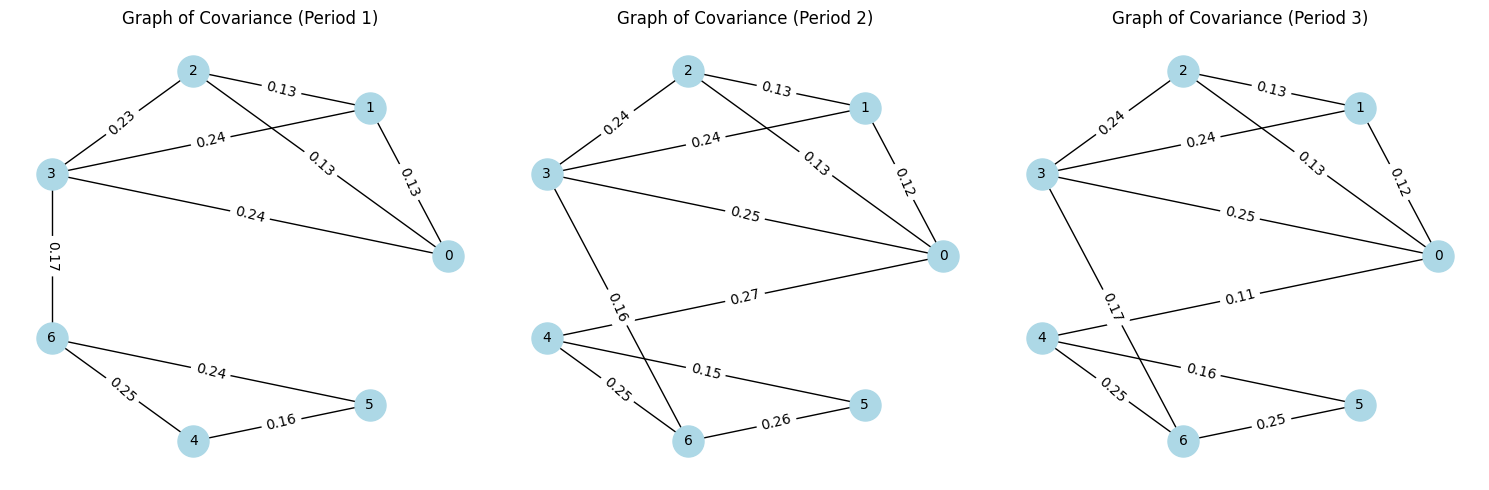

In [14]:
from data_generation import plot_graph  # or however you import the function

plot_graph([prec_est_1, prec_est_2, prec_est_concat], threshold=0.01)